# (12104) Chesley orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

In [3]:
body_id = '12104'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = nongrav_info['radius']
de_kernel = 441

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 5339 observations from the MPC.
	Filtered to 5339 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: UNK
	No debiasing needed for 4028 observations.
	Debiased 1289 observations.
	No bias information for 22 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 3181 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 2618 observations.
Read in 459 Gaia observations from gaiafpr
	Filtered to 459 observations that satisfy the time range constraints.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.757			 0.583			 2521.409			 0.218
2			 0.757			 0.581			 2532.564			 0.219
3			 0.757			 0.581			 2532.563			 0.219
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.723			 0.502			 2097.325			 0.183
5			 0.723			 0.497			 2089.216			 0.183
6			 0.723			 0.494			 2087.944			 0.183
7			 0.723			 0.492			 2086.963			 0.183
8			 0.723			 0.490			 2084.726			 0.183
9			 0.723			 0.489			 2085.235			 0.183
Converged after rejecting outliers. Rejected 80 out of 5798 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 9 (of 9):
RMS unweighted: 0.7225542754932623
RMS weighted: 0.4894941780941731
chi-squared: 2085.235149019699
reduced chi-squared: 0.18262700551932903
square root of reduced chi-squared: 0.4273488101297686
--------------------------------------------------------------
Solution Time: MJD 57961.000 TDB = 2017-07-27 00:00:00.000 TDB
Solution Observation Arc: 17592.12 days (48.16 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			2.43913904678e-02		7.35286146464e-10		2.43913929285e-02		7.68662958505e-10		+2.46069522397e-09		+3.347
q			2.93690461742e+00		3.42303981575e-09		2.93690461336e+00		3.54716292870e-09		-4.06255606933e-09		-1.187
tp			5.87282599431e+04		6.77315762978e-06		5.87282599263e+04		6.81064336410e-06		-1.67635371326e-05		-2.475
om			7.80633002818e+01		1.26172827208e-07		7.80633007170e+01		1.20942297070e-0

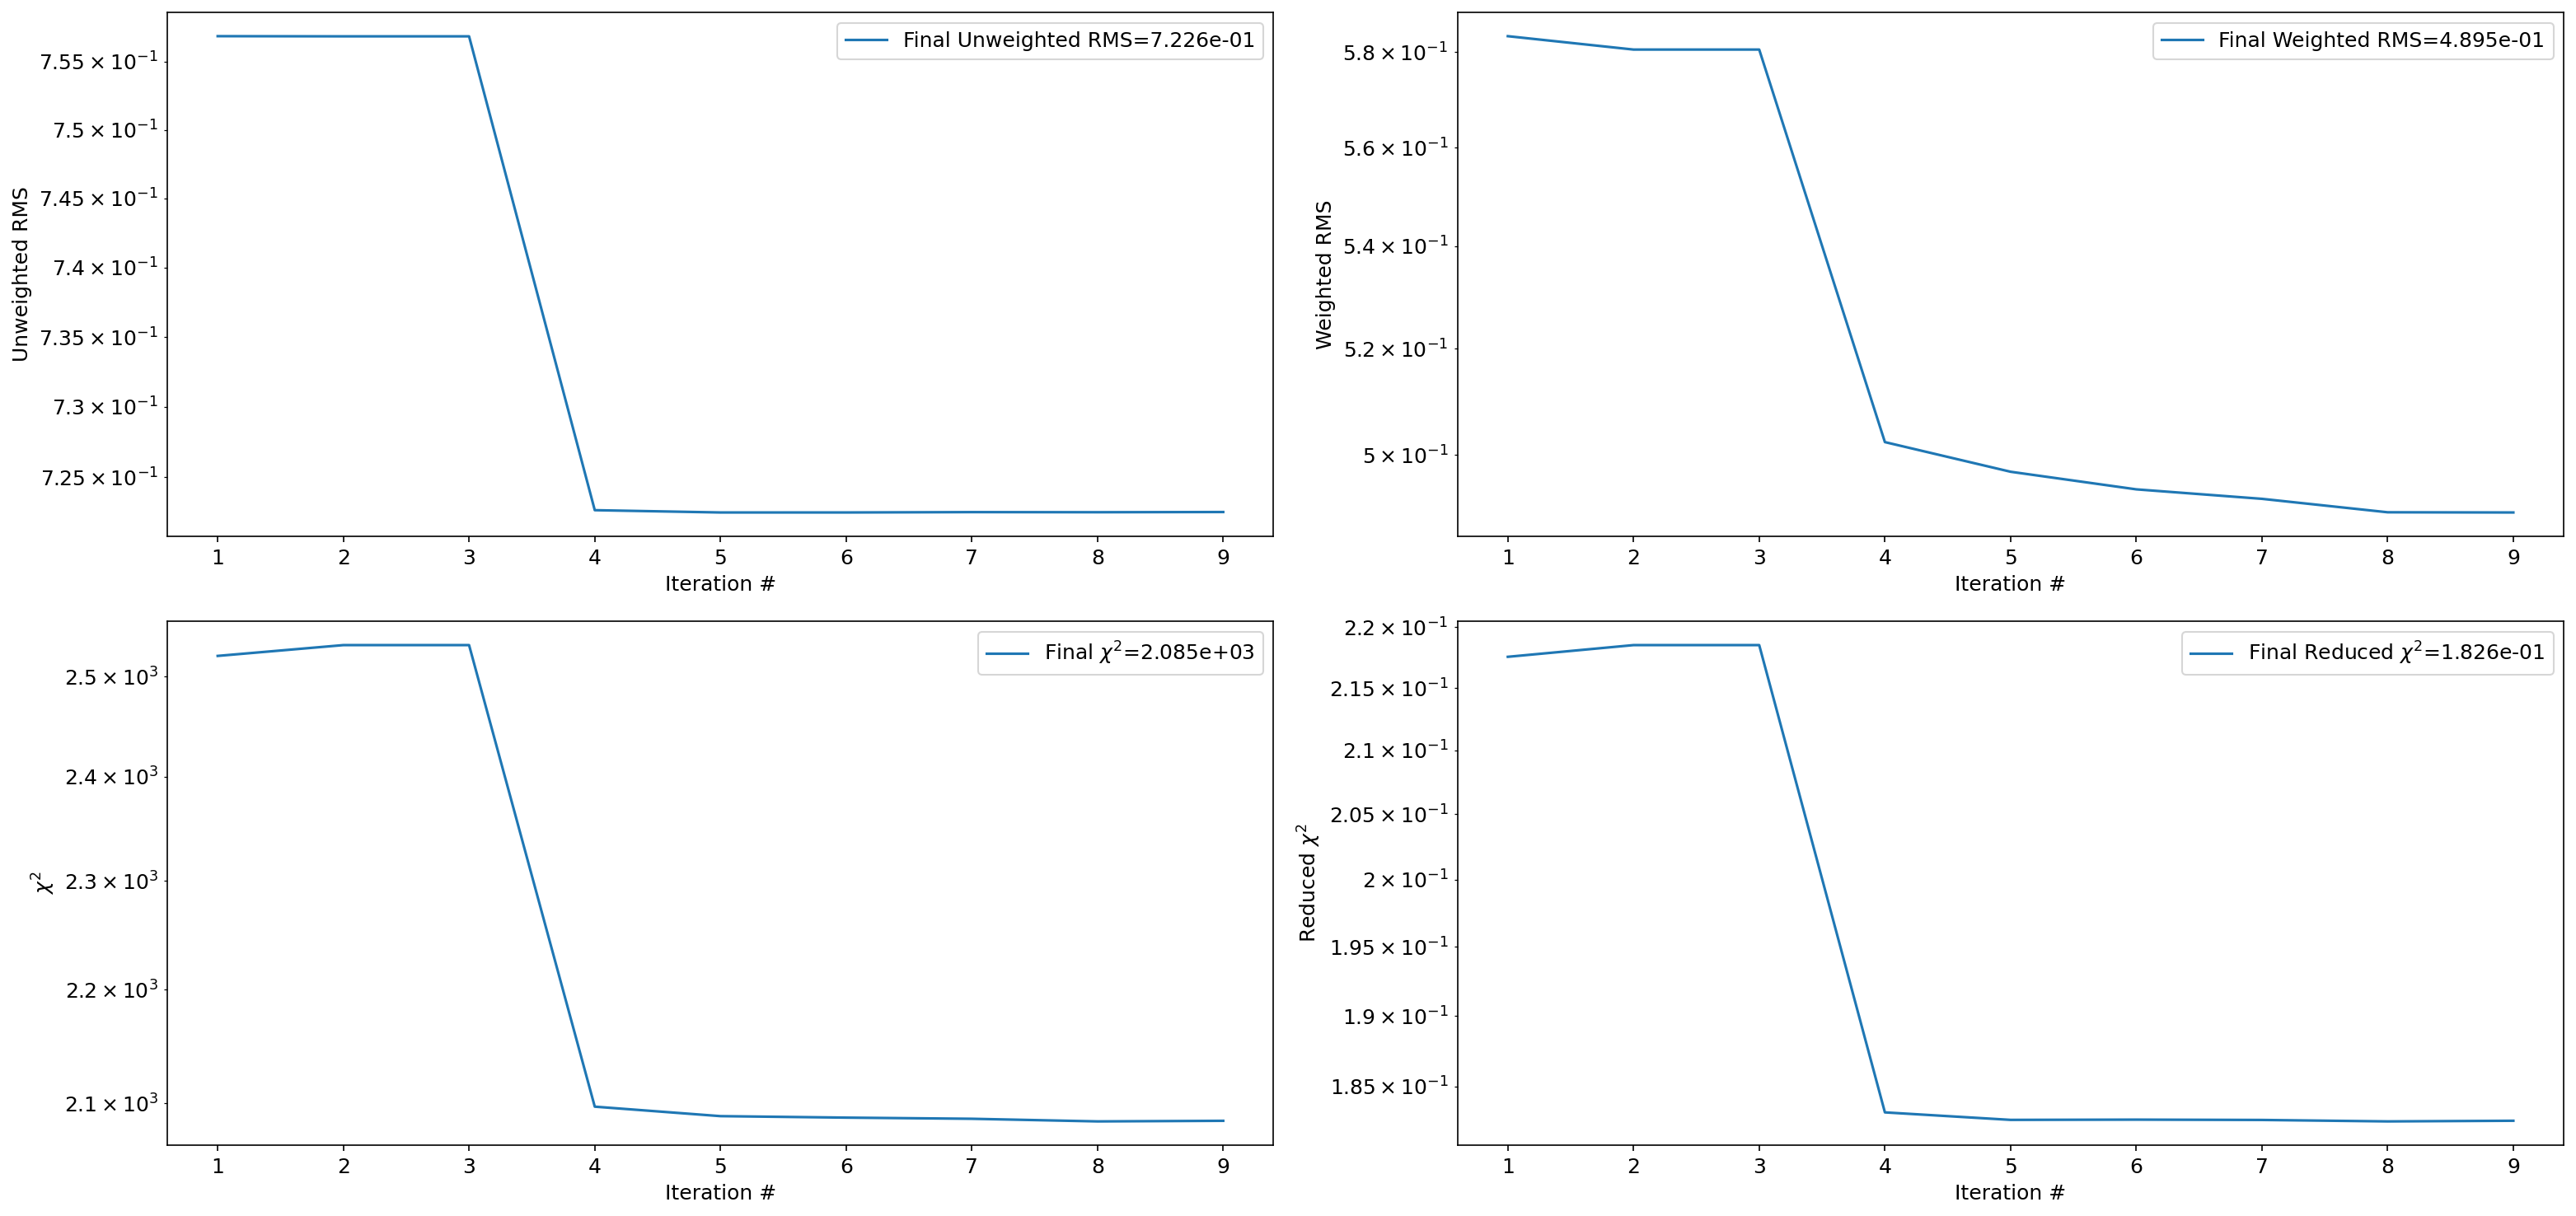

In [8]:
fit_sim.plot_summary(auto_close=True)

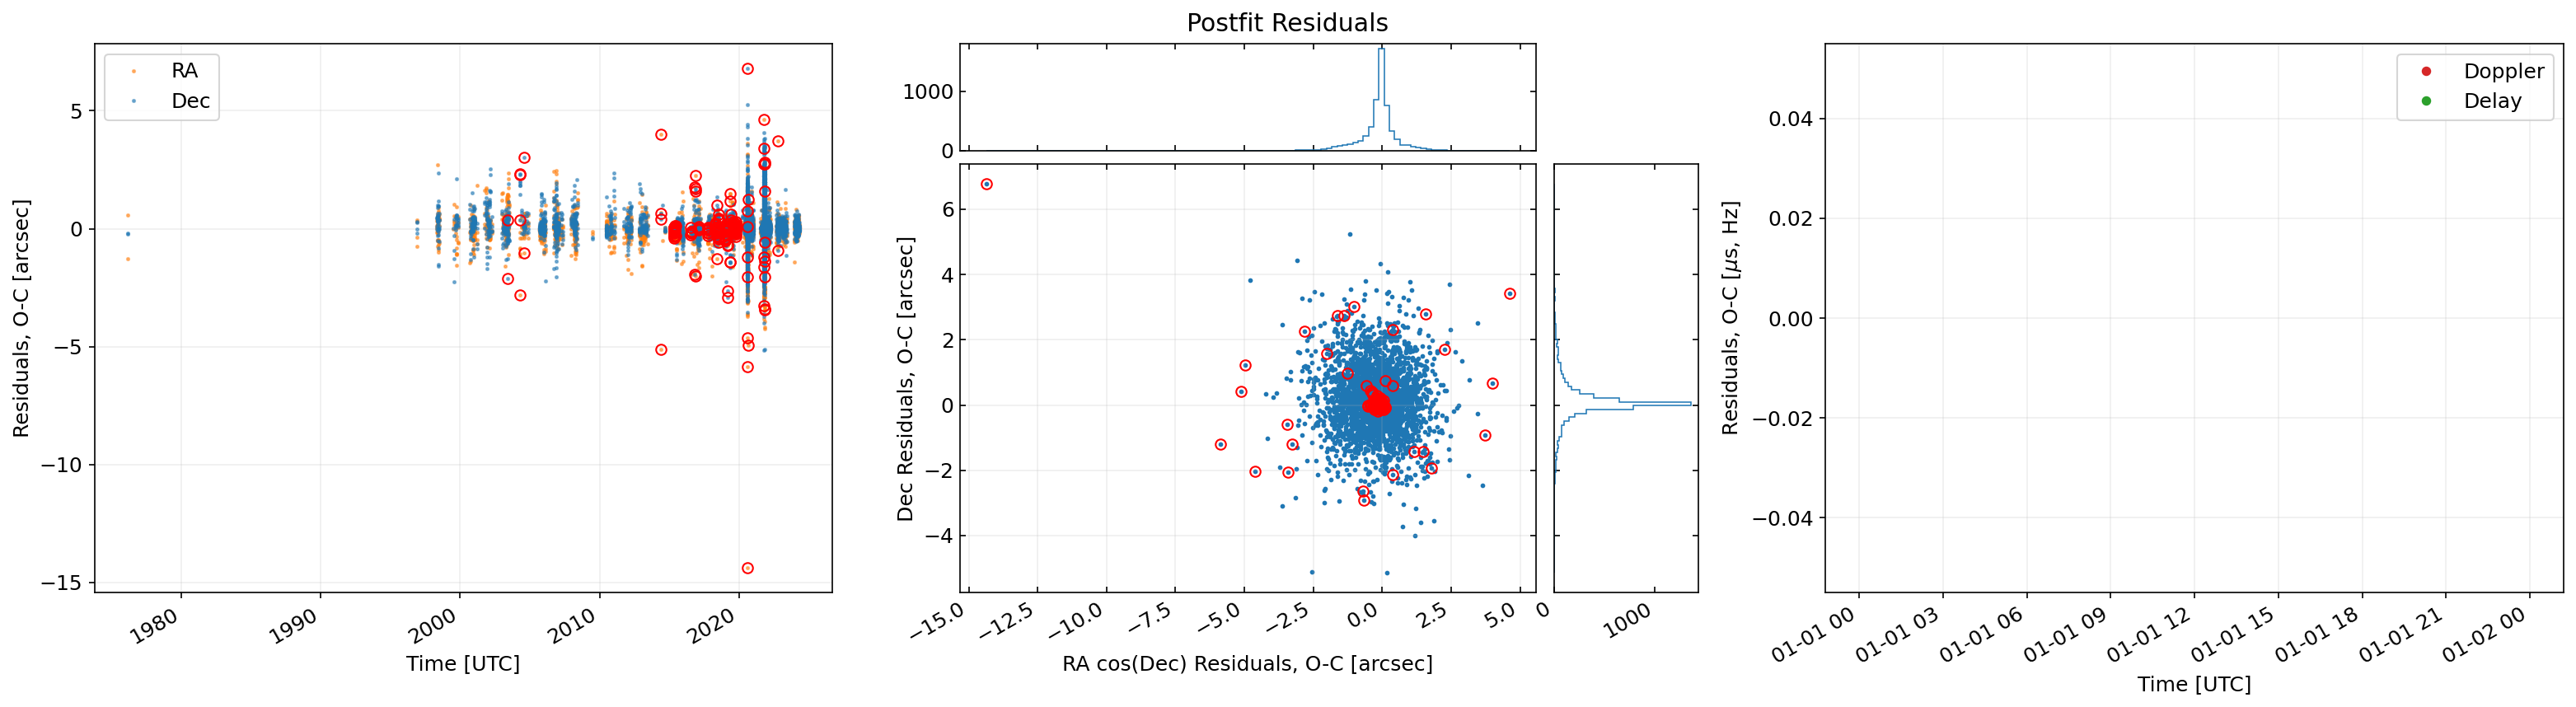

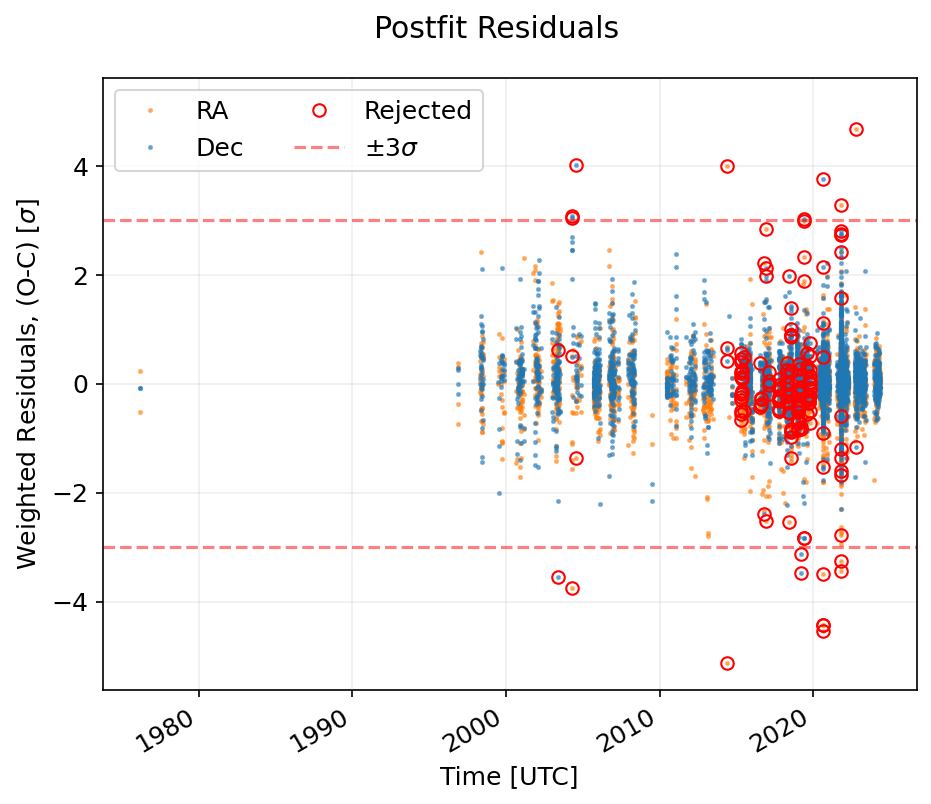

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 10.27
Mahalonobis distance between GRSS and JPL solution: 9.83
Bhattacharya distance between JPL and GRSS solution: 0.0029
Bhattacharya coefficient between JPL and GRSS solution: 0.9971


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90

AssertionError: 